# Plot the main figure in the paper for object detection
for image: sample_size_precentage = np.linspace(0.002, 0.2, 500)

for region: sample_size_precentage = np.linspace(0.001, 0.2, 500)

In [1]:
import json
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
from tools.utils_at import *

ModuleNotFoundError: No module named 'pandas'

In [27]:
method_dict = {"MC": "Random Sample","random sample": "Random Sample", "surr ensemble": "ASE Class Score 0", "ASE": "ASE Class Score 0", "ASE_regression": "ASE Regression Score 0", 
               "ASE_all": "ASE All Score 0", "ASE_class_score_1": "ASE Class Score -1", "ASE_reg_score_1": "ASE Regression Score -1", "ASE_all_score_1": "ASE All Score -1", "MPL": "MPL"}
metric_dict = {'loss': 'Loss', 'mAP': 'mAP', "mAR_1000": "mAR"}
def add_entries(file):
    #columns=['active_test_type','sample_size','loss','mAP',"AP_50", "AP_75", "mAP_samll", "mAP_medium", "mAP_large", "mAR_1", "mAR_10", "mAR_1000", "mAR_small", "mAR_medium", "mAR_large"]
    with open(file, 'r') as openfile:
        json_object = json.load(openfile)
    df = None
    for key,value in json_object.items():
        if 'test_stats' in value.keys():
            del value['test_stats']
        value['active_test_type'] = method_dict[value['active_test_type']]
        if value['sample_size'] < 1:
            continue
        temp_df = pd.DataFrame(value, index=[key])
        if df is None:
            df = temp_df
        else:
            df = pd.concat([df, temp_df],ignore_index=True)
    return df

In [44]:
def plot_all_diff_precentage_figure(input_data, baseline_data, sample_nums, y_metric, x_label_name = "% of Acquired Images", 
                                    pic_name = None):
    data = copy.deepcopy(input_data)
    f = plt.figure(figsize=(10, 8))
    font_size = 25
    data[y_metric] = abs(data[y_metric] - baseline_data[y_metric])
    data[y_metric] = data[y_metric] / baseline_data[y_metric] * 100
    print(data[y_metric].values)
    data['sample_size'] = data['sample_size'] / sample_nums * 100
    with sns.axes_style("darkgrid"):
        sns.lineplot(data=data, \
                     x='sample_size', y=y_metric, \
                     hue='active_test_type', errorbar=('sd', 1), lw=3)
        
    # x_line = [data['sample_size'][0], data['sample_size'][data['sample_size'].shape[0]-1]]
    # y_line = [0, 0]
    # plt.plot(x_line, y_line, 'r')
    # plt.title("Active Testing", fontsize=30)
    plt.xlabel(x_label_name, fontsize=font_size)# x轴标签
    plt.ylabel("% ER ", fontsize=font_size)# y轴标签
    # pic_name = scenario+'.png'
    plt.legend(fontsize = 18)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    # plt.style.use("fivethirtyeight")
    ax = plt.gca()
    ax.set_facecolor('none')
    #plt.ylim(-1600,-800)
    if pic_name is not None:
        plt.savefig(f'./figures/{pic_name}.png', bbox_inches='tight', pad_inches=0)
    plt.show()

def find_max_difference_with_each_baselines(results):
    rs = results[results["active_test_type"] == "Random Sample"]["loss"].values.reshape((-1,3)).mean(axis=1)
    ours = results[results["active_test_type"] == "our ViTAL"]["loss"].values.reshape((3,-1)).mean(axis=0)
    sample_size = results[results["active_test_type"] == "Random Sample"]["sample_size"].values.reshape((-1,3))[:,0]
    diff = np.expand_dims((1 - ours/rs), axis=0)
    diff_min = diff.min(axis=0)
    diff_min_max = diff_min.max()
    loc = sample_size[diff_min.argmax()]
    print(f"Max reducation compared with all approach: {diff_min_max:.2f}, loc : {loc}, ours: {ours[diff_min.argmax()]}, rs: {rs[diff_min.argmax()]}")    
    
def plot_figure(data, pic_name=None, x_label_name = "% of Acquired Labels", find_dff=False):
    y_metric = "loss"
    f = plt.figure(figsize=(10, 8))
    font_size = 25
    with sns.axes_style("darkgrid"):
        sns.lineplot(data=data, \
                     x='sample_size', y=y_metric, \
                     hue='active_test_type', errorbar=None, lw=3)
        
    # x_line = [data['sample_size'][0], data['sample_size'][data['sample_size'].shape[0]-1]]
    # y_line = [0, 0]
    # plt.plot(x_line, y_line, 'r')
    # plt.title("Active Testing", fontsize=30)
    # plt.xlabel(x_label_name, fontsize=font_size)# x轴标签
    # plt.ylabel("% Absolute ER ", fontsize=font_size)# y轴标签
    plt.title("")
    plt.xlabel("")# x轴标签
    plt.ylabel("")# y轴标签
    # pic_name = scenario+'.png'
    # plt.legend(fontsize = 18)
    plt.legend([])
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.tight_layout()
    # plt.style.use("fivethirtyeight")
    ax = plt.gca()
    ax.set_facecolor('none')
    if pic_name is not None:
        # plt.savefig(f"./figures/{pic_name}.pdf",dpi=800)
        plt.savefig(f'./figures/{pic_name}.png', bbox_inches='tight', pad_inches=0)
    plt.show()
    if find_dff:
        find_max_difference_with_each_baselines(data)

def read_baseline_data(data_path):
    with open(data_path, 'r') as openfile:
        none_swin_data = json.load(openfile)
    return none_swin_data["0"]

def take_data_for_defined_point(model_dataset, steps, image_path, result_path, level):
    if model_dataset[-1] == "0":
        model_origin_folder = "_".join(model_dataset.split("_")[:-1])
    else:
        model_origin_folder = model_dataset
    base_path = f"./pro_data/{model_origin_folder}/val/"
    sample_size_threshold = np_read(base_path + image_path).shape[0]
    result_json_path = f"./results/{model_dataset}/{result_path}/"
    true_loss_estimation_path = result_json_path + "None.json"
    test_whole_data = read_baseline_data(true_loss_estimation_path)
    results = add_entries(result_json_path + "random_sample_3_runs.json")
    vit_results = add_entries(result_json_path + f"ViT_{level}_runs_{steps}.json")
    results = pd.concat([results, vit_results], ignore_index=True)
    min_size = int(min_size_p * sample_size_threshold)
    max_size = int(max_size_p * sample_size_threshold)
    results = results[results['sample_size'] >= min_size]
    results = results[results['sample_size'] <= max_size]
    y_metric = "loss"
    results[y_metric] = abs(results[y_metric] - test_whole_data[y_metric])
    results[y_metric] = results[y_metric] / test_whole_data[y_metric] * 100
    results['sample_size'] = results['sample_size'] / sample_size_threshold * 100
    return results

def print_mean_std(path, test_whole_data, sample_size_threshold):
    global temp_list
    data = add_entries(path)
    min_size = int(min_size_p * sample_size_threshold)
    max_size = int(max_size_p * sample_size_threshold)
    data = data[data['sample_size'] >= min_size]
    data = data[data['sample_size'] <= max_size]
    data = data['loss'].values
    data = data.reshape(3, data.shape[0]//3)
    data = (np.abs(data - test_whole_data) / test_whole_data) * 100
    mean = data.mean()
    std = data.mean(axis=1).std()
    print(f"{path}: mean {mean:.2f}, std {std:.2f}")
    temp_list.append(mean)
    temp_list.append(std)

def show_all_methods_mean_std(model_dataset, steps, image_path, result_path, level):
    global temp_list, result_pd
    if model_dataset[-1] == "0":
        model_origin_folder = "_".join(model_dataset.split("_")[:-1])
    else:
        model_origin_folder = model_dataset
    base_path = f"./pro_data/{model_origin_folder}/val/"
    sample_size_threshold = np_read(base_path + image_path).shape[0]
    result_json_path = f"./results/{model_dataset}/{result_path}/"
    test_whole_data = read_baseline_data(result_json_path + "None.json")['loss']
    temp_list = []
    print_mean_std(result_json_path + "random_sample_3_runs.json", test_whole_data, sample_size_threshold)
    print_mean_std(result_json_path + f"ViT_{level}_runs_{steps}.json", test_whole_data, sample_size_threshold)
    print("====================================================================================================")
    result_pd[model_dataset] = copy.deepcopy(temp_list)

def compute_average_std(std):
    print(f"{np.sqrt(np.sum(np.power(std,2)/std.shape[0])):.2f}")

## image

In [49]:
method_dict = {"random sample": "Random Sample", "ViT all": "our ViTAL"}
result_pd = {}
temp_list = []
min_size_p = 0.01
max_size_p = 0.1
def take_image_data_for_one_model_dataset(model_dataset, steps = 10000):
    if model_dataset[-1] == "0":
        model_origin_folder = model_dataset[:-3]
    else:
        model_origin_folder = model_dataset
    base_path = f"./pro_data/{model_origin_folder}/val/"
    sample_size_threshold = np_read(base_path + "image_true_losses.npy").shape[0]
    result_json_path = f"./results/{model_dataset}/image_based_active_testing/"
    true_loss_estimation_path = result_json_path + "None.json"
    test_whole_data = read_baseline_data(true_loss_estimation_path)
    results = add_entries(result_json_path + "random_sample_3_runs.json")
    vit_results = add_entries(result_json_path + f"ViT_all_runs_{steps}.json")
    results = pd.concat([results, vit_results],ignore_index=True)
    y_metric = "loss"
    results[y_metric] = abs(results[y_metric] - test_whole_data[y_metric])
    results[y_metric] = results[y_metric] / test_whole_data[y_metric] * 100
    results['sample_size'] = results['sample_size'] / sample_size_threshold * 100
    return results

def take_image_data_for_defined_point(model_dataset, steps = 10000):
    return take_data_for_defined_point(model_dataset, steps, "image_true_losses.npy", "image_based_active_testing", "all")

def show_image_all_methods_mean_std(model_dataset, steps = 10000):
    show_all_methods_mean_std(model_dataset, steps, "image_true_losses.npy", "image_based_active_testing", "all")

In [46]:
dataset_model = "DETR_COCO"
step_array = np.arange(10000, 100001, 10000)
for step in step_array:
    show_image_all_methods_mean_std(dataset_model, step)

./results/DETR_COCO/image_based_active_testing/random_sample_3_runs.json: mean 3.52, std 1.99
./results/DETR_COCO/image_based_active_testing/ViT_all_runs_10000.json: mean 1.21, std 0.08
./results/DETR_COCO/image_based_active_testing/random_sample_3_runs.json: mean 3.52, std 1.99
./results/DETR_COCO/image_based_active_testing/ViT_all_runs_20000.json: mean 1.33, std 0.43
./results/DETR_COCO/image_based_active_testing/random_sample_3_runs.json: mean 3.52, std 1.99
./results/DETR_COCO/image_based_active_testing/ViT_all_runs_30000.json: mean 2.03, std 0.63
./results/DETR_COCO/image_based_active_testing/random_sample_3_runs.json: mean 3.52, std 1.99
./results/DETR_COCO/image_based_active_testing/ViT_all_runs_40000.json: mean 2.91, std 0.99
./results/DETR_COCO/image_based_active_testing/random_sample_3_runs.json: mean 3.52, std 1.99
./results/DETR_COCO/image_based_active_testing/ViT_all_runs_50000.json: mean 0.90, std 0.35
./results/DETR_COCO/image_based_active_testing/random_sample_3_runs.js

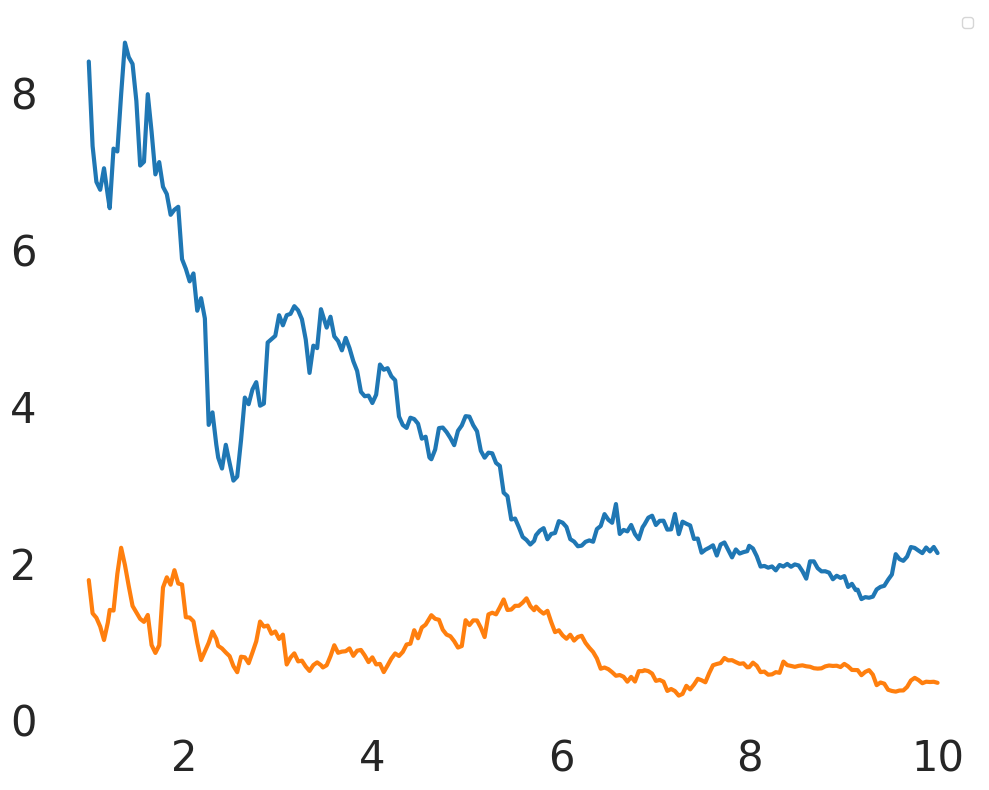

In [47]:
results = take_image_data_for_defined_point("DETR_COCO", 50000)
# plot_figure(results, "Image_VOC")
plot_figure(results)

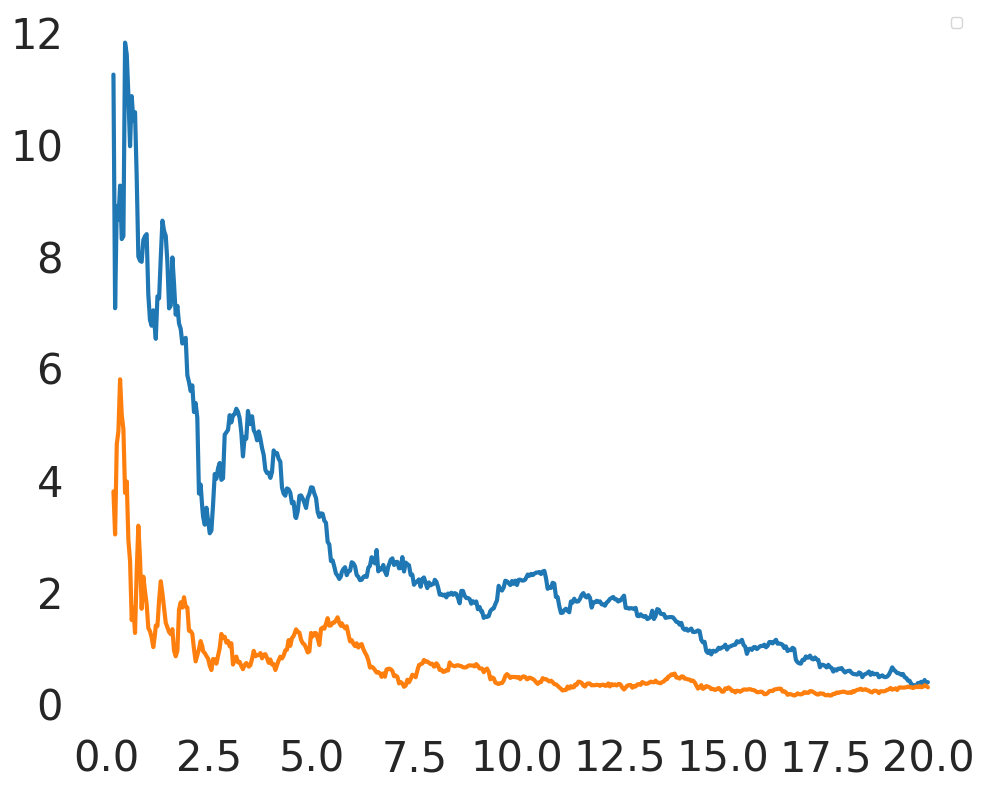

In [50]:
results = take_image_data_for_one_model_dataset("DETR_COCO", 50000)
plot_figure(results)

## region

In [58]:
min_size_p = 0.01
max_size_p = 0.05

def take_region_data_for_one_model_dataset(model_dataset, steps = 10000):
    if model_dataset[-1] == "0":
        model_origin_folder = "_".join(model_dataset.split("_")[:-1])
    else:
        model_origin_folder = model_dataset
    base_path = f"./pro_data/{model_origin_folder}/val/"
    sample_size_threshold = np_read(base_path + "region_true_losses.npy").shape[0]
    result_json_path = f"./results/{model_dataset}/region_based_active_testing/"
    true_loss_estimation_path = result_json_path + "None.json"
    test_whole_data = read_baseline_data(true_loss_estimation_path)
    results = add_entries(result_json_path + "random_sample_3_runs.json")
    vit_results = add_entries(result_json_path + f"ViT_all_runs_{steps}.json")
    results = pd.concat([results, vit_results], ignore_index=True)
    y_metric = "loss"
    results[y_metric] = abs(results[y_metric] - test_whole_data[y_metric])
    results[y_metric] = results[y_metric] / test_whole_data[y_metric] * 100
    results['sample_size'] = results['sample_size'] / sample_size_threshold * 100
    return results

def take_region_data_for_defined_point(model_dataset,  steps = 10000):
    return take_data_for_defined_point(model_dataset,  steps, "region_true_losses.npy", "region_based_active_testing", "all")

def show_region_all_methods_mean_std(model_dataset, steps = 10000):
    show_all_methods_mean_std(model_dataset, steps, "region_true_losses.npy", "region_based_active_testing", "all")

In [60]:
dataset_model = "DETR_COCO"
step_array = np.arange(10000, 100001, 10000)
for step in step_array:
    show_region_all_methods_mean_std(dataset_model, step)

./results/DETR_COCO/region_based_active_testing/random_sample_3_runs.json: mean 0.98, std 0.40
./results/DETR_COCO/region_based_active_testing/ViT_all_runs_10000.json: mean 0.44, std 0.04
./results/DETR_COCO/region_based_active_testing/random_sample_3_runs.json: mean 0.98, std 0.40
./results/DETR_COCO/region_based_active_testing/ViT_all_runs_20000.json: mean 0.35, std 0.08
./results/DETR_COCO/region_based_active_testing/random_sample_3_runs.json: mean 0.98, std 0.40
./results/DETR_COCO/region_based_active_testing/ViT_all_runs_30000.json: mean 0.56, std 0.23
./results/DETR_COCO/region_based_active_testing/random_sample_3_runs.json: mean 0.98, std 0.40
./results/DETR_COCO/region_based_active_testing/ViT_all_runs_40000.json: mean 0.37, std 0.24
./results/DETR_COCO/region_based_active_testing/random_sample_3_runs.json: mean 0.98, std 0.40
./results/DETR_COCO/region_based_active_testing/ViT_all_runs_50000.json: mean 0.56, std 0.13
./results/DETR_COCO/region_based_active_testing/random_sampl

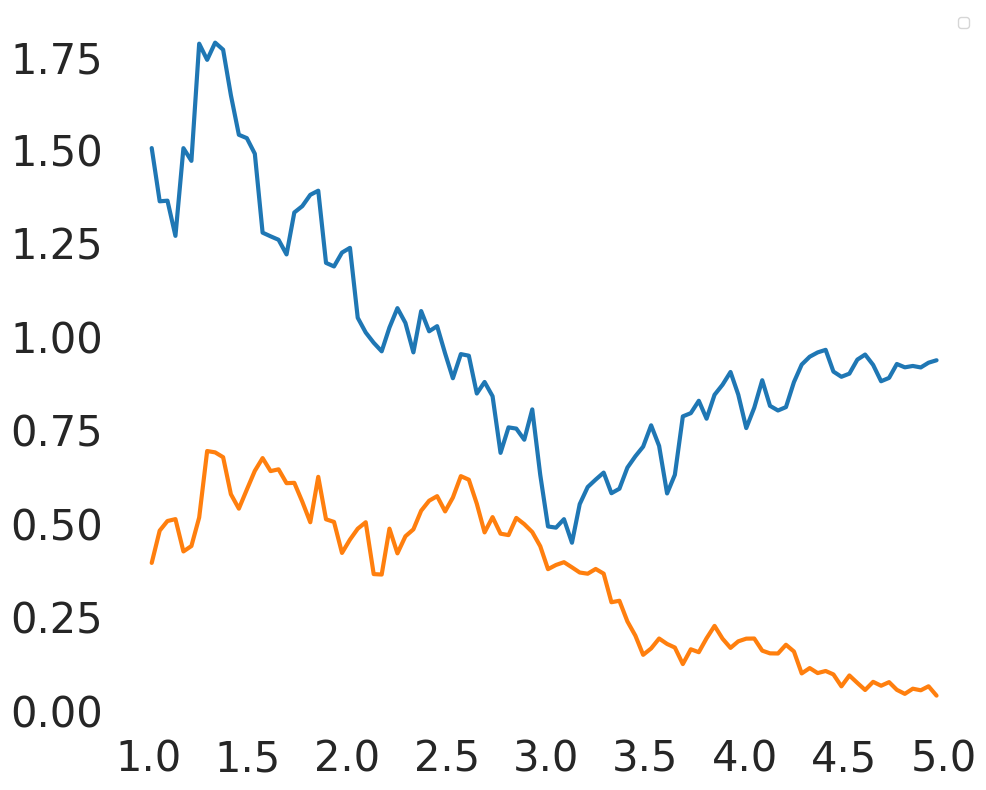

In [61]:
results = take_region_data_for_defined_point("DETR_COCO",  20000)
plot_figure(results)

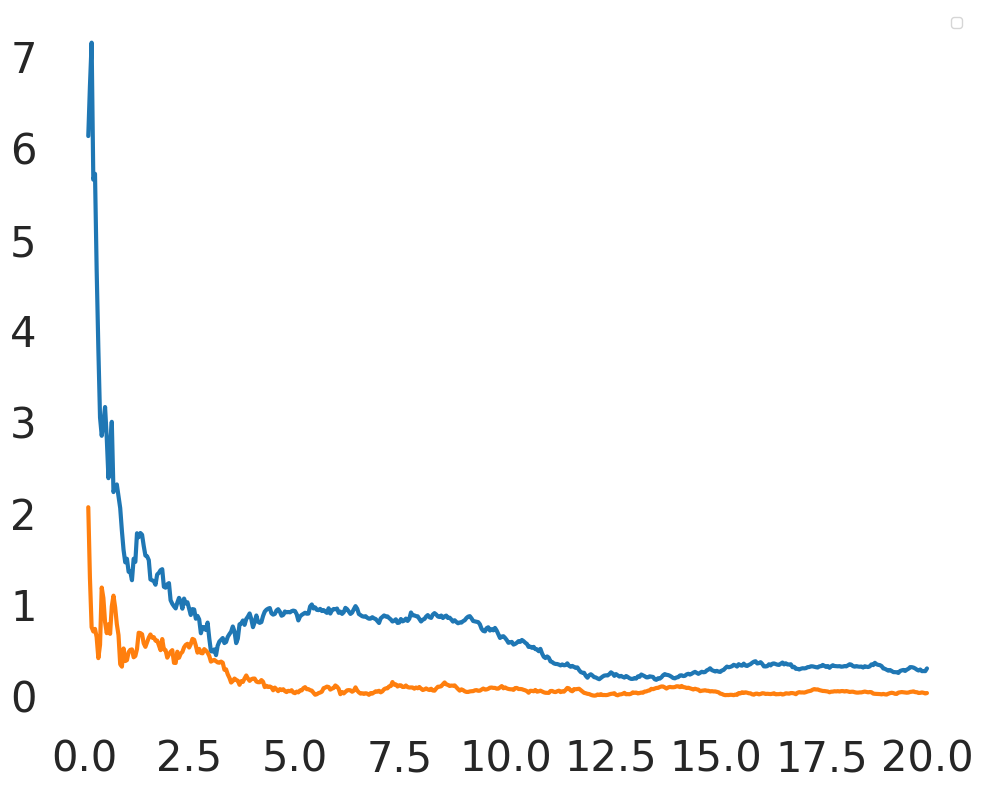

In [62]:
results = take_region_data_for_one_model_dataset("DETR_COCO",  20000)
plot_figure(results)